Ngày 1:
Chủ đề: Xử lý dữ liệu cảm biến nhiệt độ (Temperature Sensor).
TƯ DUY TỔNG QUÁT: Tôi đang đo cái gì? Đo để làm gì? và quyết định được gì khi dựa trên số liệu đó?.
Mục tiêu: 
    - Hiểu dữ liệu cảm biến là gì?.
    - Biết python xử lý dữ liệu sensor như thế nào?.
    - Dùng được: Biến, hàm, list, vòng lặp.
    - Vẽ được biểu đồ nhiệt độ theo thời gian.

 Định nghĩa bài toán:
 Một motor trong nhà máy SMT có sensor nhiệt độ như sau:
    - Đo mỗi 1 phút, liên tục trong vòng 60 phút.
    - Nhiệt độ bình thường được xác định trong khoảng: 40-70 độ C.
    - Có thể xuất hiện nhiệt bất thường.
 Nhiệm vụ:
    - Cell 0: Import thư viện liên quan.
    - Cell 1: Tạo dữ liệu nhiệt độ.
    - Cell 2: Lưu vào cấu trúc python.
    - Cell 3: Phân tích.
    - Cell 4: Vẽ biểu đồ.


In [1]:
import random
from decimal import Decimal,ROUND_HALF_UP
import matplotlib.pyplot as plt

In [2]:
temperature_data = []

for sample in range(100):
    temp = Decimal(str(random.uniform(40,70))).quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
    temperature_data.append(temp)  #sensor gửi dữ liệu
temperature_data[:3]

[Decimal('58.33'), Decimal('44.64'), Decimal('51.49')]

In [3]:
from datetime import datetime, timedelta

timestamped_data = []
start_time = datetime.now() # Thời điểm bắt đầu đo
interval = timedelta(seconds=10)  # 6 giây lấy mẫu một lần

for i, temp in enumerate(temperature_data):
    record = {
        'timestamp': start_time + i * interval,
        'temperature': temp
    }
    timestamped_data.append(record)

timestamped_data[:3]

[{'timestamp': datetime.datetime(2025, 12, 23, 19, 59, 48, 298652),
  'temperature': Decimal('58.33')},
 {'timestamp': datetime.datetime(2025, 12, 23, 19, 59, 58, 298652),
  'temperature': Decimal('44.64')},
 {'timestamp': datetime.datetime(2025, 12, 23, 20, 0, 8, 298652),
  'temperature': Decimal('51.49')}]

In [4]:
max_temp = max(temperature_data)
min_temp = min(temperature_data)
avg_temp = sum(temperature_data) / len(temperature_data)

print(f"Max Temp: {max_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)} °C")
print(f"Min Temp: {min_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)} °C")
print(f"Average Temp: {avg_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)} °C")

Max Temp: 69.36 °C
Min Temp: 40.60 °C
Average Temp: 55.14 °C


In [5]:
def analyze_temperature(data):
    if not data:
        return None
    
    max_temp = max(data)
    min_temp = min(data)
    avg_temp = sum(data) / Decimal(len(data))
    
    return{
        "max": max_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP),
        "min": min_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP),
        "avg": avg_temp.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
    }
result = analyze_temperature(temperature_data)
result

{'max': Decimal('69.36'), 'min': Decimal('40.60'), 'avg': Decimal('55.14')}

In [6]:
times = [d["timestamp"] for d in timestamped_data]
temps = [float(d["temperature"]) for d in timestamped_data]

In [7]:
OVERHEAT_THRESHOLD = Decimal('65.00')

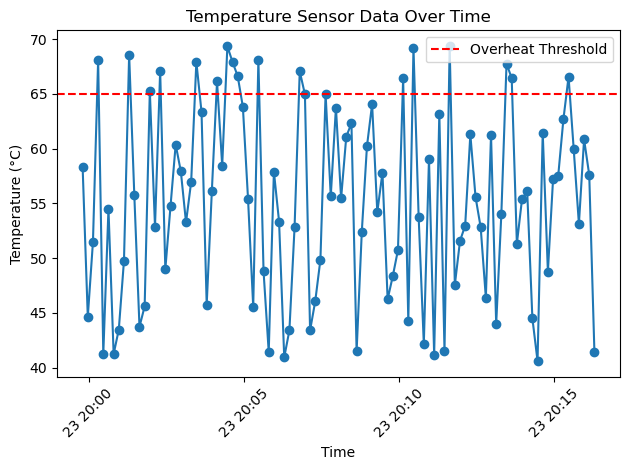

In [8]:
plt.figure()
plt.plot(times, temps, marker='o')
plt.axhline(y=float(OVERHEAT_THRESHOLD), color='r', linestyle='--', label='Overheat Threshold')
plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Sensor Data Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()